In [1]:
# !pip install weaviate-client
# !pip install openai
from dotenv import load_dotenv
import weaviate
import csv
import os
from os import listdir
from datetime import datetime, timezone
from weaviate.batch import Batch 
from weaviate.util import generate_uuid5 
from os.path import basename

# Load the .env file
load_dotenv()

# Retrieve the OpenAI API key from the environment variables
OPENAI_KEY = os.getenv("OPENAI_KEY")

WEAVIATE_IP_ADDRESS = "34.42.138.162"

# RAG with Weaviate Demonstration

## Introduction

This notebook contains a working process we've developed for RAG. It's not intended to be ready for production, but instead as the source of production code. It describes a web scraper designed to scrape websites based on their `sitemap.xml`. For every page scraped, a CSV file is generated containing the scraped content. The filename of the CSV embeds the website address (e.g., `www.apple.com`) and a timestamp indicating when the scraping took place.

Given that there's a length constraint on the documents (e.g., a limit of 500 words), the schema is designed to handle segmented portions of the scraped text, termed as "text chunks".

## CSV Structure

Each CSV file has the following structure:

- **Filename**: `{websiteAddress}_{timestamp}.csv`
- **Columns**:
  - **key**: An identifier for the text chunk, typically indicating the webpage (e.g., `https://www.apple.com/iphone/`).
  - **text**: The content of the text chunk, representing a segment of the webpage's content.

## Schema Overview

The core data structure is the `TextChunk` class, representing a portion of text scraped from a webpage.

### TextChunk

- **Description**: A segmented portion of text from a scraped webpage with full details.

#### Properties:

- **key** (`string`): The identifier for the text chunk. It's generated based on the specific webpage URL and the chunk number, e.g., `{data['key']}_chunk_{i}`.
  
- **text** (`string`): The content of the text chunk. Given the constraints on document length, this content may represent only a segment of the full webpage's text.

- **pageURL** (`string`): The specific URL of the scraped webpage this chunk originates from.

- **websiteAddress** (`string`): The root address of the website from which this chunk was scraped.

- **timestamp** (`date`): The date and time indicating when this chunk was scraped.

### Additional Configuration:

The `TextChunk` class utilizes the `text2vec-openai` vectorizer with a module configuration set for `gpt-3.5-turbo` from OpenAI. The class is also set up with an inverted index configuration to index timestamps.

In [2]:
schema = {
    "classes": [
        {
            "class": "TextChunk",
            "description": "A segmented portion of text from a scraped webpage with full details.",
            "invertedIndexConfig": {
                "indexTimestamps": True
            },
            "vectorizer": "text2vec-openai",
            "moduleConfig": {
                "generative-openai": {
                    "model": "gpt-3.5-turbo"
                }
            },
            "properties": [
                {
                    "name": "key",
                    "dataType": ["string"],
                    "description": "The identifier for the text chunk.",
                    "indexInverted": True
                },
                {
                    "name": "text",
                    "dataType": ["string"],
                    "description": "The content of the text chunk.",
                    "indexInverted": True
                },
                {
                    "name": "pageURL",
                    "dataType": ["string"],
                    "description": "The specific URL of the scraped webpage this chunk belongs to.",
                    "indexInverted": True
                },
                {
                    "name": "websiteAddress",
                    "dataType": ["string"],
                    "description": "The address of the website this chunk comes from.",
                    "indexInverted": True
                },
                {
                    "name": "timestamp",
                    "dataType": ["date"],
                    "description": "The date and time when the chunk was scraped.",
                    "indexInverted": True
                }
            ]
        }
    ]
}


Retrieval-Augmented Generation (RAG) systems such as the one we're creating, combine the power of large-scale transformers with external retrieval or database mechanisms. They allow for real-time fetching of relevant external context, which is then used to assist in generating the final output.

Since we can't give an LLM the entire set of information we have to answer a question, we have to split it into chunks of text. For a model like GPT-3.5 with a maximum context size of 4096 tokens, this translates to about a maximum context size of 3000 words. However, we also have to account for the response of the model, as the maximum context includes the size of the completion as well. Therefore realistically, we should keep our total number of words less than 2000. The means that $n_{chunks}$ x $size_{chunk}$ needs to be less than 2000.

There is a trade-off between text chunk size and the number of chunks, there are a few key points to keep in mind:

### Context Granularity
   - **Chunk Size**: Larger chunks provide more context in each retrieval, which can be beneficial if the answer to a question is spread out or requires understanding a broader context.
   - **Number of Chunks**: Retrieving a higher number of smaller chunks can be beneficial if the information is quite specific and located in smaller, discrete portions of the data.

### Retrieval Speed and Efficiency
   - **Chunk Size**: Larger chunks might slow down the retrieval process as they require more time to be fetched and processed.
   - **Number of Chunks**: If you retrieve a large number of chunks, it can also slow down the retrieval process, especially if the underlying database/retrieval mechanism isn't optimized for high-throughput, low-latency operations.

### Model Complexity and Computational Overhead
   - **Chunk Size**: Larger chunks mean that the model has to process more data at once, increasing the computational overhead and potentially leading to a higher risk of missing key details.
   - **Number of Chunks**: While processing multiple smaller chunks might seem computationally more manageable, combining and cross-referencing information across chunks can introduce its own complexity.

### Memory Limitations
   - Both larger chunk sizes and a higher number of chunks can be constrained by memory limitations, especially when dealing with models that have a fixed context window size (like the 4096 tokens limit in GPT-3.5). If a chunk or the combined set of chunks exceeds this limit, it can lead to truncation or omission of data.

### Noise vs. Signal
   - **Chunk Size**: Larger chunks might bring in more noise along with the relevant signal, especially if only a small portion of the chunk is relevant to the query at hand.
   - **Number of Chunks**: Fetching more chunks increases the likelihood of retrieving relevant pieces of information, but it might also introduce more noise, making it harder for the model to focus on the most pertinent details.

In [3]:
# Parameters for the RAG process

# Size (in # of words) of the chunks
text_chunk_size = 500

# Number of text chunks of size text_chunk_size to retrieve
num_chunks = 2

# Maximum number of tokens we want in our response
maximum_tokens = 1000

In [4]:
def create_date(date_string):
    """
    Convert a date string to RFC 3339 formatted string with timezone.

    Parameters:
    - date_string (str): Input date string in the format "%Y-%m-%dT%H-%M-%S".

    Returns:
    - str: RFC 3339 formatted date-time string.
    """
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H-%M-%S")
    # convert datetime object to RFC 3339 string (with timezone)
    rfc3339_string = dt_object.replace(tzinfo=timezone.utc).isoformat()
    return rfc3339_string


# Initialize Weaviate client
client = weaviate.Client(
    # Weaviate instance URL
    url="http://" + WEAVIATE_IP_ADDRESS + ":8080",
    additional_headers={
        # Replace with your OpenAI key
        "X-OPENAI-Api-Key": OPENAI_KEY,
    }
)

# # Delete existing schema (caution: this deletes the current structure)
# client.schema.delete_all()

# # Here we use the schema created in the previous cell.
# client.schema.create(schema)
# print("Schema was created.")

# Function to load data from CSV folder and extract website name and timestamp from filename
def load_csv_data(directory):
    """
    Load CSV data from a given directory, extracting website name and timestamp from filenames.

    Parameters:
    - directory (str): The directory path containing the CSV files.

    Returns:
    - list[dict]: List of dictionaries containing rows from all CSVs.
    """
    all_data = []
    for filename in listdir(directory):
        if filename.endswith('.csv'):
            website_name, timestamp = filename.rsplit('.', 1)[0].split('_')
            timestamp = create_date(timestamp)
            with open(f"{directory}/{filename}", mode='r') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    row['websiteAddress'] = website_name
                    row['timestamp'] = timestamp
                    all_data.append(row)
    return all_data

# Function to load data from a single CSV and extract website name and timestamp from filename
def load_csv_data_from_file(file_path):
    """
    Load CSV data from a given file, extracting website name and timestamp from filename.

    Parameters:
    - file_path (str): The file path of the CSV file.

    Returns:
    - list[dict]: List of dictionaries containing rows from the CSV.
    """
    all_data = []
    filename = basename(file_path)
    if filename.endswith('.csv'):
        website_name, timestamp = filename.rsplit('.', 1)[0].split('_')
        timestamp = create_date(timestamp)
        with open(file_path, mode='r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                row['websiteAddress'] = website_name
                row['timestamp'] = timestamp
                all_data.append(row)
    return all_data

# Load CSV data
# data_directory = './sample_data'

csv_data = load_csv_data_from_file("./sample_data/descript.com_2023-10-07T06-47-45.csv")

def split_into_chunks(string, text_chunk_size):
    """
    Split a string into chunks of a specified size (word count).

    Parameters:
    - string (str): The input string to be split.
    - text_chunk_size (int): The desired word count for each chunk.

    Returns:
    - list[str]: List containing chunks of the input string.
    """
    words = string.split()
    chunks = []
    chunk = ""
    
    # Split into chunks
    for idx, word in enumerate(words):
        if idx % text_chunk_size == 0 and idx > 0:
            chunks.append(chunk.strip())
            chunk = ""
        chunk += word + " "
    
    # Add last chunk to list by concatenating with last chunk in the list
    if chunk and len(chunks) > 0:
        chunks[-1] += chunk.strip()
        # chunks.append(chunk.strip())
        
    # If there's only one chunk, return list with one chunk
    elif chunk:
        chunks.append(chunk.strip())
    return chunks

In [5]:
csv_data # Output not shown becaus GitHub displays all of it, and it's long

[{'key': 'https://www.descript.com/about',
  'text': "about | descript squadcast is joining descript! get remote recording free. learn more â\x86\x92 product tour features for work resources pricing sign in sign up about descript descript is a new kind of video editor thatâ\x80\x99s as easy as a doc. descriptâ\x80\x99s ai-powered features and intuitive interface fuel youtube and tiktok channels, top podcasts, and businesses using video for marketing, sales, and internal training and collaboration. descript aims to make video a staple of every communicatorâ\x80\x99s toolkit, alongside docs and slides. if you'd like to learn about how the company got started, we wrote a post about it . descript has raised a total of $100m, primarily from openai startup fund, andreessen horowitz , redpoint ventures , and spark capital . individual investors include daniel gross, devdatta akhawe, alex blumberg, jack conte, justine ezarik, todd goldberg, jean-denis greze, john lilly, tobi lutke, bharat medi

In [6]:
# Extract the website address and timestamp from the csv data
csv_website_address = csv_data[0]['websiteAddress']
csv_timestamp = csv_data[0]['timestamp']

def text_chunk_exists(client, website_address, timestamp):
    """
    Check if a TextChunk with a specific website address and timestamp already exists in Weaviate.

    Parameters:
    - client (weaviate.Client): The Weaviate client object to interact with the Weaviate instance.
    - website_address (str): The website address to check.
    - timestamp (str): The timestamp to check in RFC 3339 format.

    Returns:
    - bool: True if the TextChunk exists in Weaviate, False otherwise.
    """
    
    # GraphQL query to retrieve TextChunk based on website address and timestamp
    query = f"""
    {{
      Get {{
        TextChunk (where: {{
            operator: And
            operands: [{{
                path: ["websiteAddress"],
                operator: Equal,
                valueString: "{website_address}"
            }}, {{
                path: ["timestamp"],
                operator: Equal,
                valueDate: "{timestamp}"
            }}]
        }}) {{
          __typename
        }}
      }}
    }}
    """

    result = client.query.raw(query)
    print(result) # Print the result for debugging
    
    # Check if the TextChunk exists based on the query results
    return len(result['data']['Get']['TextChunk']) > 0

# Check if a TextChunk with data from the CSV already exists
already_exists = text_chunk_exists(client, csv_website_address, csv_timestamp)

{'data': {'Get': {'TextChunk': []}}}


In [7]:
from weaviate.batch import Batch 
from weaviate.util import generate_uuid5 

# Check if the data does not already exist in Weaviate
# If it does, we don't need to import it again. This uses
# weaviate batching for better efficiency.
if not already_exists:
    # Configure the batch size
    client.batch.configure(batch_size=20)

    for data in csv_data:
        chunks = split_into_chunks(data["text"], text_chunk_size)
        
        # For each chunk, generate a unique key and create a TextChunk object
        for i, chunk in enumerate(chunks):
            # Create each chunk as a separate TextChunk object
            text_chunk = {
                "key": f"{data['key']}_chunk_{i}",
                "text": chunk,
                "pageURL": data["key"],
                "websiteAddress": data["websiteAddress"],
                "timestamp": data["timestamp"]
            }

            # Generate a unique UUID for this TextChunk
            text_chunk_id = generate_uuid5(f"{data['websiteAddress']}_chunk_{i}{data['timestamp']}")

            # Add the data object to Weaviate using batch
            client.batch.add_data_object(data_object=text_chunk, class_name="TextChunk", uuid=text_chunk_id)

    # Flush the batch to make sure all data is submitted
    client.batch.flush()

In [8]:
client.schema.get()

{'classes': [{'class': 'TextChunk',
   'description': 'A segmented portion of text from a scraped webpage with full details.',
   'invertedIndexConfig': {'bm25': {'b': 0.75, 'k1': 1.2},
    'cleanupIntervalSeconds': 60,
    'indexTimestamps': True,
    'stopwords': {'additions': None, 'preset': 'en', 'removals': None}},
   'moduleConfig': {'generative-openai': {'model': 'gpt-3.5-turbo'},
    'text2vec-openai': {'model': 'ada',
     'modelVersion': '002',
     'type': 'text',
     'vectorizeClassName': True}},
   'multiTenancyConfig': {'enabled': False},
   'properties': [{'dataType': ['text'],
     'description': 'The identifier for the text chunk.',
     'indexFilterable': True,
     'indexSearchable': True,
     'moduleConfig': {'text2vec-openai': {'skip': False,
       'vectorizePropertyName': False}},
     'name': 'key',
     'tokenization': 'whitespace'},
    {'dataType': ['text'],
     'description': 'The content of the text chunk.',
     'indexFilterable': True,
     'indexSearc

In [9]:
# Ensure everything is in Weaviate via GraphQL
query = """
{
  Get {
    TextChunk {
      key
      text
      pageURL
      websiteAddress
      timestamp
    }
  }
}
"""

# Retrieve it and print it for debugging.
# This output has been snipped as it's too long.
result = client.query.raw(query)
print(result)

{'data': {'Get': {'TextChunk': [{'key': 'https://www.descript.com/terms_chunk_12', 'pageURL': 'https://www.descript.com/terms', 'text': 'the extent that any claims must therefore proceed on a class, collective, consolidated, or representative basis, such claims must be litigated in a civil court of competent jurisdiction and not in arbitration, and the parties agree that litigation of those claims shall be stayed pending the outcome of any individual claims in arbitration. further, if any part of this section is found to prohibit an individual claim seeking public injunctive relief, that provision will have no effect to the extent such relief is allowed to be sought out of arbitration, and the remainder of this section will be enforceable. opt-out - you have the right to opt out of binding arbitration within 30 days of the date you first accepted the terms of this section 20 by writing to us at attn: legal, 385 grove street, san francisco, ca 94102 telephone number:(415) 231-7449 e-mai

In [10]:
# Let's ask GPT-3.5 something brand specific to the company Chooch AI.
# It would only know through this context we are providing
text_to_search = "What is Descript?"

# Construct a filter to narrow down the search results based on specific conditions:
# 1) The website address must be "www.chooch.com"
# 2) The timestamp of the data chunk must be "2023-10-03T15:30:00+00:00"
where_filter = {
    "operator" : "And",
    "operands" : [
        {
            "path": ["websiteAddress"],
            "operator": "Equal",
            "valueString": "descript.com"
        },
        {
            "path": ["timestamp"],
            "operator": "Equal",
            "valueDate": "2023-10-07T06:47:45+00:00"
        }
    ]
}

# Execute the query on the Weaviate client:
# - Target the "TextChunk" class in Weaviate
# - Retrieve the "text" property of the relevant chunks
# - Limit the results based on the defined number of chunks (num_chunks)
# - Use semantic search to find text chunks that are conceptually similar to the query
# - Apply the defined filters (where_filter) to narrow down the search results
# - Execute the constructed query
results = client.query.get('TextChunk', ['text','pageURL']) \
    .with_limit(num_chunks) \
    .with_near_text({'concepts': [text_to_search]}) \
    .with_where(where_filter) \
    .do()

print(results)

{'data': {'Get': {'TextChunk': [{'pageURL': 'https://www.descript.com/terms', 'text': 'rights to post or share on the descript service. you will not create, upload, transmit, publish or otherwise use, on or in connection with the descript service, any user content that: (a) infringes upon or violates the rights of any third party including any copyright, trademark, trade secret, or other intellectual property rights, rights of publicity, rights of privacy, or contract rights; (b) is illegal, defamatory, obscene, pornographic, vulgar, indecent, lewd, offensive, threatening, abusive, harmful, inflammatory, deceptive, false, misleading, or fraudulent; (c) promotes hatred, discrimination, bigotry, racism, harassment, violence or harm against any individual or group; (d) violates, or encourages any conduct that would violate, any applicable laws, rules or regulations or give rise to any civil liability; (e) contains any viruses, corrupted data or other harmful, disruptive or destructive fil

In [11]:
# Define a string template for framing questions in a standardized format.
# The template is designed to clearly separate the context information from the question itself,
# ensuring that the context is explicitly provided each time a question is asked.

# - {context_str} is a placeholder for the context information.
# - {question} is a placeholder for the actual question being posed.

QUESTION_TEMPLATE = (
    "Context information is below. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the question: {question}\n"
)

In [26]:
import openai

# Extract the Relevant Context Information
context_texts = [chunk['text'] for chunk in results['data']['Get']['TextChunk']]
context_str = "\n".join(context_texts)

# Construct the Full Query for GPT-3.5
query_string = QUESTION_TEMPLATE.format(context_str=context_str, question=text_to_search)

# Set up the OpenAI API key
openai.api_key = OPENAI_KEY

# Query GPT-3.5
response_generator = openai.Completion.create(
  engine="gpt-3.5-turbo-instruct",
  prompt=text_to_search,
  max_tokens=maximum_tokens,
  stream=True
)

## Our RAG version of GPT-3.5 can answer the question as it has the context

In [27]:
# Iterate over the generator to get responses
for response in response_generator:
    print(response.choices[0].text, end='')



Descript is a collaborative audio and video editor that simplifies the editing process by transcribing the spoken word in media files and allowing users to edit the text as if editing a document. This allows for easy manipulation of the audio or video, such as deleting, rearranging or adding new content, and also allows for easy searching and organization of the media files based on the transcribed text. Descript also has features such as built-in AI voice cloning and real-time collaboration, making it a versatile tool for content creators, podcasters, and other media professionals.

## Querying GPT-3.5 shows it is not aware of the answer to this question without the context

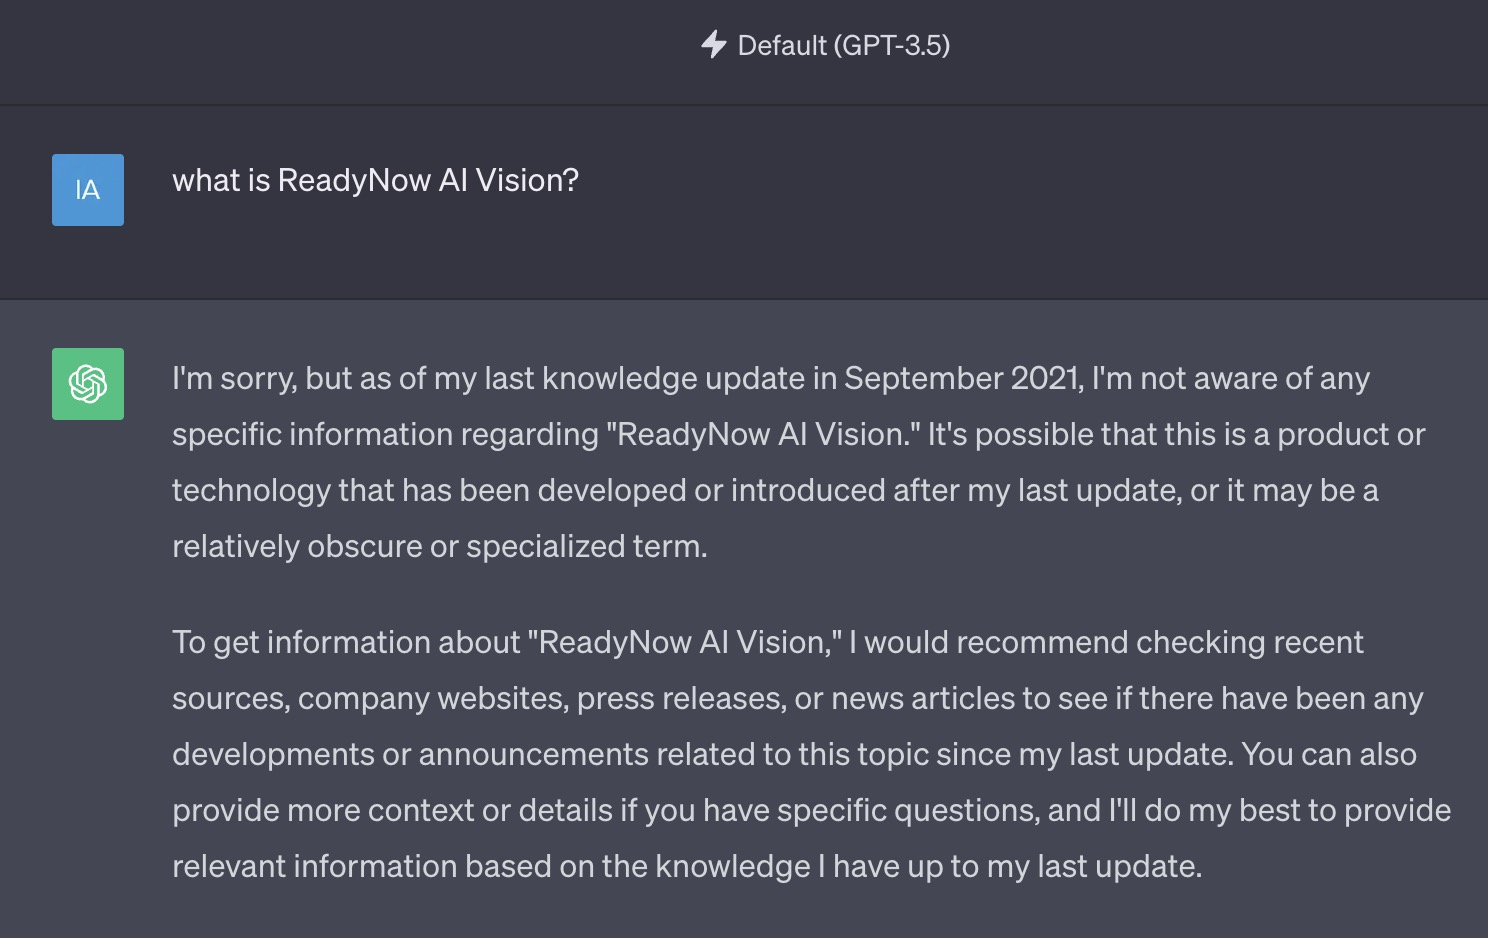